In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.shape

(1338, 7)

In [4]:
data['sex_binary'] = np.where(data['sex'] == 'female', 0, 1)

In [5]:
data['smoker_binary'] = np.where(data['smoker'] == 'yes', 1, 0)
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_binary,smoker_binary
0,19,female,27.900,0,yes,southwest,16884.92400,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0


In [6]:
data['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [7]:
conditions = [(data['region'] == 'southwest'), (data['region'] == 'southeast'), (data['region'] == 'northwest'), (data['region'] == 'northeast')]

In [8]:
values_region = [0, 1, 2, 3]

In [9]:
data['region_binary'] = np.select(conditions, values_region)
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_binary,smoker_binary,region_binary
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0
1,18,male,33.770,1,no,southeast,1725.55230,1,0,1
2,28,male,33.000,3,no,southeast,4449.46200,1,0,1
3,33,male,22.705,0,no,northwest,21984.47061,1,0,2
4,32,male,28.880,0,no,northwest,3866.85520,1,0,2


In [10]:
clean_data = data.copy()
clean_data = clean_data.drop(['sex', 'smoker', 'region'], axis = 1)
clean_data.head()

,age,bmi,children,charges,sex_binary,smoker_binary,region_binary
0,19,27.900,0,16884.92400,0,1,0
1,18,33.770,1,1725.55230,1,0,1
2,28,33.000,3,4449.46200,1,0,1
3,33,22.705,0,21984.47061,1,0,2
4,32,28.880,0,3866.85520,1,0,2


<AxesSubplot: >

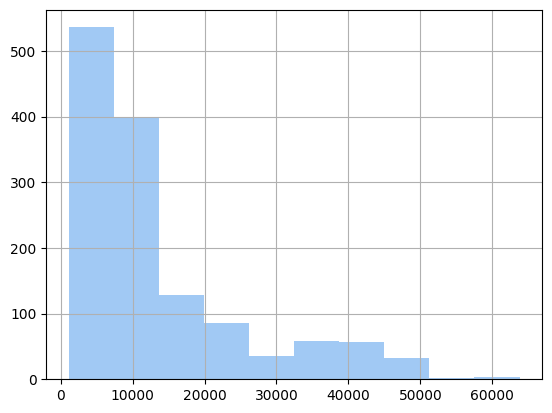

In [77]:
data['charges'].hist()

<AxesSubplot: >

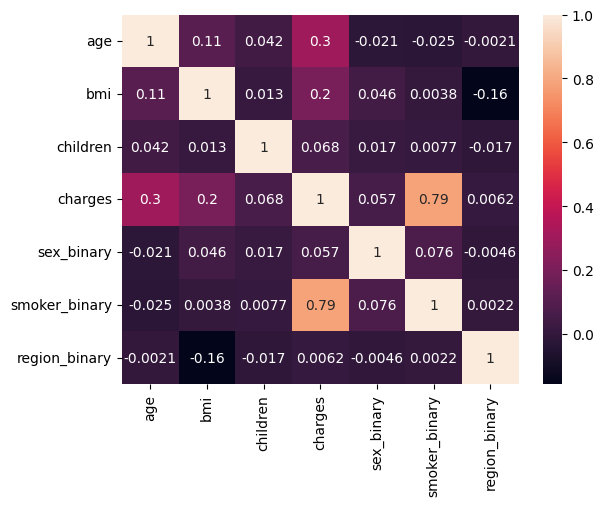

In [11]:
sns.heatmap(clean_data.corr(), annot=True)


- $H_0$ - ціна медичного страхування не залежить від куріння
- $H_1$ - ціна медичного страхування залежить від куріння

In [12]:
x_smoke = clean_data[clean_data['smoker_binary'] == 0]['charges']
y_smoke = clean_data[clean_data['smoker_binary'] == 1]['charges']

In [13]:
def two_histagrams(x, x_name, y, y_name):
    x.hist(alpha = 0.5, weights = [1/len(x)]*len(x), color = 'green', label=x_name)
    y.hist(alpha = 0.5, weights = [1/len(y)]*len(y), color = 'red', label=y_name)
    plt.axvline(x.mean(), color = 'green', ls='--', label='mean '+x_name)
    plt.axvline(y.mean(), color = 'red', ls='dashdot', label='mean '+y_name)
    plt.legend()
    plt.show()

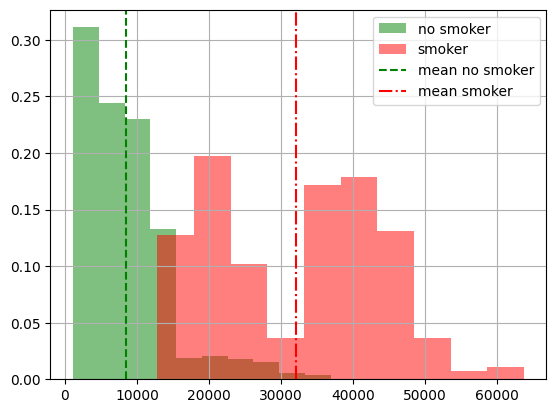

In [14]:
two_histagrams(x_smoke, 'no smoker', y_smoke, 'smoker')

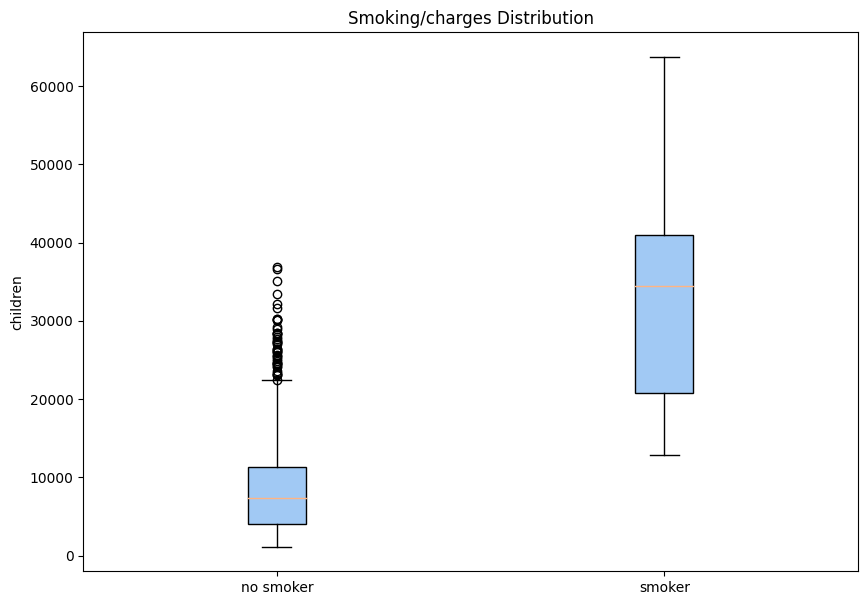

In [24]:
box_plot([x_smoke, y_smoke], ['no smoker', 'smoker'], "Smoking/charges Distribution")

- дані розподілені не нормально, тому будемо використовувати для дослідження метод Манна - Уітні

In [15]:
def mana(x, y):
    result = stats.mannwhitneyu(x, y)
    return result

In [16]:
print(mana(x_smoke, y_smoke))

MannwhitneyuResult(statistic=7403.0, pvalue=5.270233444503571e-130)


- за отриманими значеннями статистики та p значення можемо прийняти альтернативну гіпотезу, та сказати, що куріння впливає на ціну медичного страхування.

- $H_0$ - ціна медичного страхування не залежить від кількості дітей/їх наявності
- $H_1$ - ціна медичного страхування залежить від кількості дітей/їх наявності

In [20]:
def box_plot(values, names, title):
    sns.set_palette("pastel")
    fig = plt.figure(figsize =(10, 7))
    plt.title(title)
    plt.boxplot(values, patch_artist=True, labels=names)
    plt.ylabel('children')
    plt.show()

In [18]:
x_children = clean_data[clean_data['children'] == 0]['charges']
y_children = clean_data[clean_data['children'] == 1]['charges']
z_children = clean_data[clean_data['children'] == 2]['charges']
a_children = clean_data[clean_data['children'] == 3]['charges']

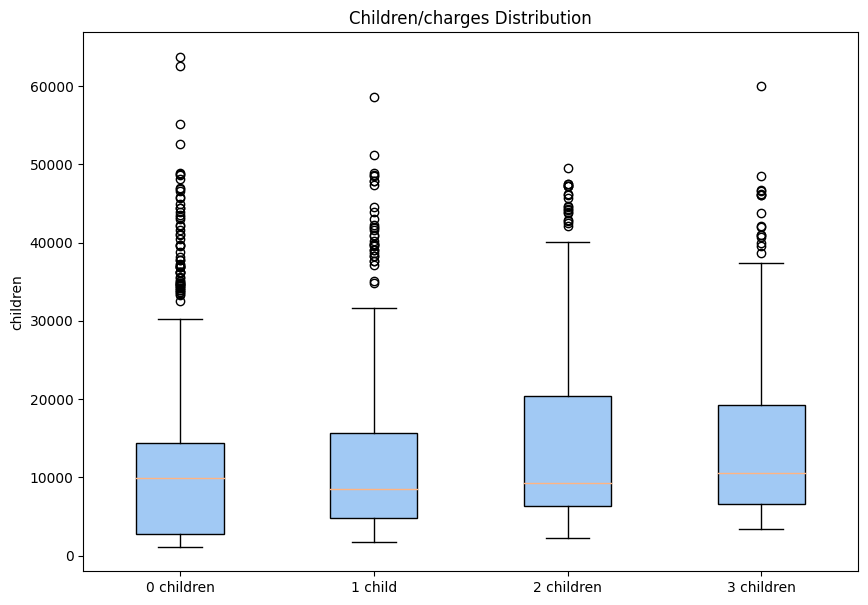

In [36]:
box_plot([x_children, y_children, z_children, a_children], ['0 children', '1 child', '2 children', '3 children'], "Children/charges Distribution")

In [28]:
def anova(*args):
    return stats.f_oneway(*args)

In [29]:
print(anova(x_children, y_children, z_children, a_children))

F_onewayResult(statistic=4.548095589979123, pvalue=0.003539750476652319)


- за результатами ANOVA, можемо сказати, що кількість дітей не значно, але впливає на вартість медичного страхування


- $H_0$ - ціна медичного страхування не залежить від регіону
- $H_1$ - ціна медичного страхування залежить від регіону

In [30]:
x_region = clean_data[clean_data['region_binary'] == 0]['charges']
y_region = clean_data[clean_data['region_binary'] == 1]['charges']
z_region = clean_data[clean_data['region_binary'] == 2]['charges']
a_region = clean_data[clean_data['region_binary'] == 3]['charges']

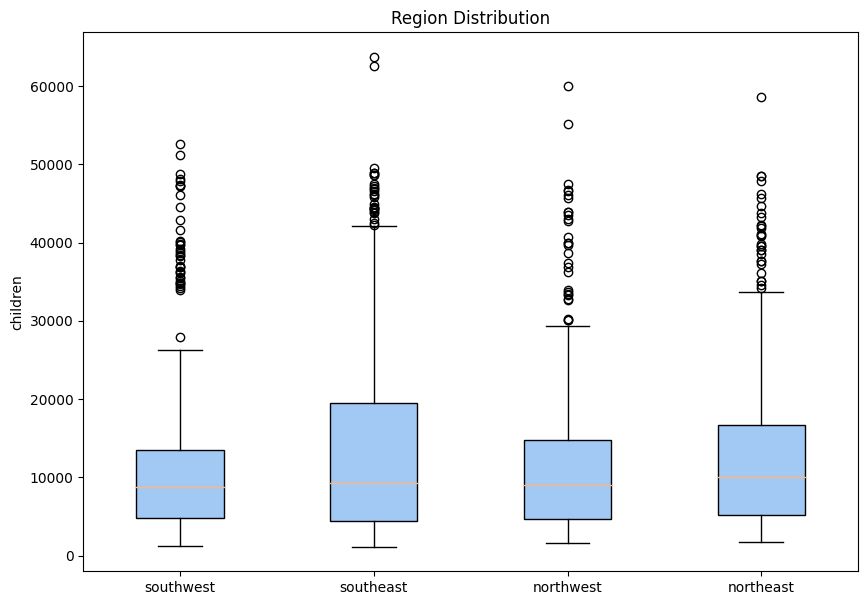

In [32]:
box_plot([x_region, y_region, z_region,  a_region], ['southwest', 'southeast', 'northwest', 'northeast'], 'Region Distribution')

In [33]:
print(anova(x_region, y_region, z_region, a_region))

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)


- регіон не значно, але впливає на вартість медичного страхування


- $H_0$ - ціна медичного страхування не залежить від статі
- $H_1$ - ціна медичного страхування залежить від статі

In [34]:
x_sex = clean_data[clean_data['sex_binary'] == 0]['charges']
y_sex = clean_data[clean_data['sex_binary'] == 1]['charges']

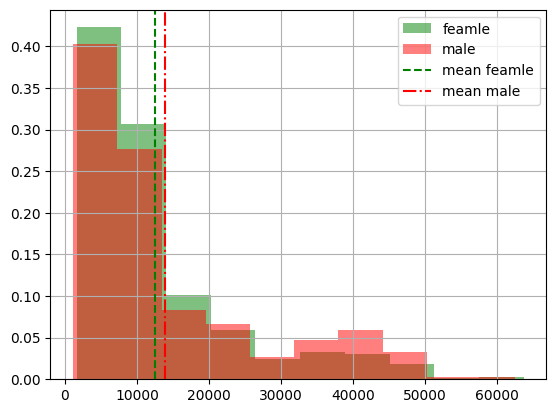

In [35]:
two_histagrams(x_sex, 'feamle', y_sex, 'male')

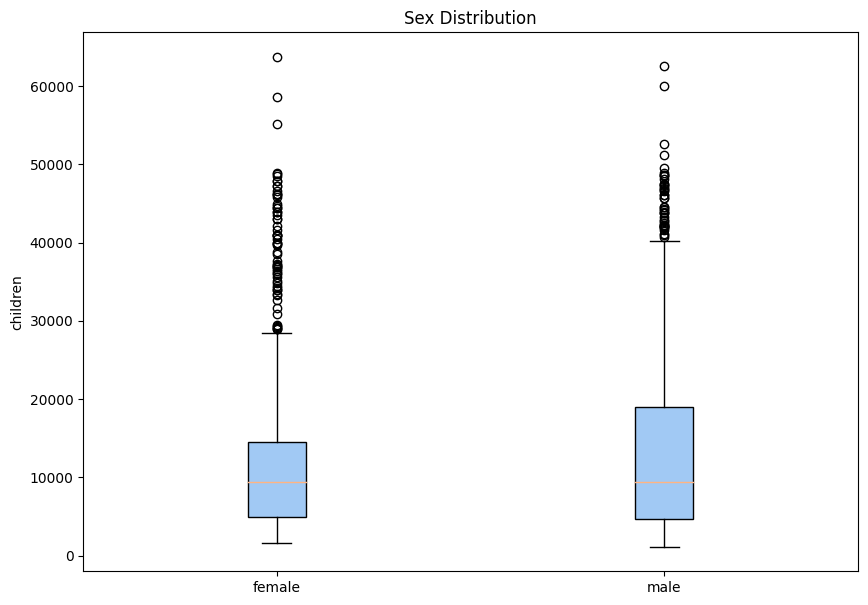

In [37]:
box_plot([x_sex, y_sex], ['female', 'male'], 'Sex Distribution')

In [38]:
print(mana(x_sex, y_sex))

MannwhitneyuResult(statistic=221304.0, pvalue=0.7286510894470093)


- стать не впливає на ціну медичного страхування

- $H_0$ - ціна медичного страхування не залежить від індексу маси тіла
- $H_1$ - ціна медичного страхування залежить від індексу маси тіла

In [39]:
def corr(x, y):
    return stats.pearsonr(x, y)

In [40]:
print(corr(clean_data['bmi'], clean_data['charges']))

PearsonRResult(statistic=0.19834096883362876, pvalue=2.459085535118126e-13)


- P-значення дуже мале, що вказує на вагомі докази проти нульової гіпотези про відсутність кореляції між двома змінними. Таким чином, ми можемо зробити висновок, що існує статистично значущий зв’язок між ІМТ та ціною медичного страхування.
- Однак важливо зазначити, що сила зв’язку лише помірна (з коефіцієнтом кореляції 0,198), що означає, що дві змінні не сильно корелюють. Іншими словами, зміни в одній змінній не можуть точно передбачити зміни в іншій змінній, хоча між ними все ще існує статистично значущий зв’язок.

- $H_0$ - ціна медичного страхування не залежить від віку
- $H_1$ - ціна медичного страхування залежить від віку

In [41]:
print(corr(clean_data['age'], clean_data['charges']))

PearsonRResult(statistic=0.29900819333064743, pvalue=4.8866933317214925e-29)


- отриманий результат є аналогічним до ІМТ

In [42]:
clean_data = clean_data.drop(['sex_binary'], axis = 1)

In [43]:
clean_data.head()

,age,bmi,children,charges,smoker_binary,region_binary
0,19,27.900,0,16884.92400,1,0
1,18,33.770,1,1725.55230,0,1
2,28,33.000,3,4449.46200,0,1
3,33,22.705,0,21984.47061,0,2
4,32,28.880,0,3866.85520,0,2


In [44]:
features = clean_data.loc[:, clean_data.columns != 'charges']

In [45]:
target = clean_data['charges']

In [46]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)

In [78]:
linear = LinearRegression()

In [79]:
linear.fit(x_train, y_train)

LinearRegression()

In [80]:
linear_pred = linear.predict(x_test)

In [81]:
coef_det = metrics.r2_score(y_test, linear_pred)
r2_percent = coef_det * 100

In [82]:
r2_percent

76.97211527941855

In [83]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [84]:
poly_model.fit(x_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('linear', LinearRegression(fit_intercept=False))])

In [85]:
poly_pred = poly_model.predict(x_test)

In [87]:
coef_det = metrics.r2_score(y_test, poly_pred)
r2_percent = coef_det * 100

In [88]:
r2_percent

86.40692348359225

In [52]:
score_depth_leaf = []
plot_score = []
plot_depth = []
for i in range(1, 20):
    for j in range(1, 10):
        model_res = DecisionTreeRegressor(random_state=42, max_depth= i, min_samples_leaf= j)
        score = cross_val_score(model_res, x_train, y_train, cv = 5)
        score_depth_leaf.append((score.mean(), i, j))
        plot_depth.append(i)
        plot_score.append(score.mean())

def take_score(elem: tuple):
    return elem[0]

max_score = max(score_depth_leaf, key=take_score)
best_score, best_depth, min_leaf = max_score

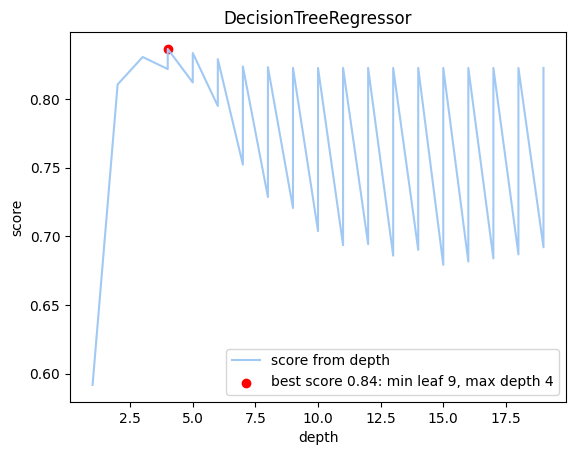

In [53]:
plt.title(f"DecisionTreeRegressor")
plt.xlabel('depth')
plt.ylabel('score')
sns.set_palette("pastel")

plt.plot(plot_depth, plot_score, label = 'score from depth')
plt.scatter(best_depth, best_score, color = 'red', label = f'best score {best_score.round(2)}: min leaf {min_leaf}, max depth {best_depth}')

plt.legend()
plt.show()

In [55]:
tree_model = DecisionTreeRegressor(max_depth= best_depth, min_samples_leaf = min_leaf)

In [56]:
tree_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=9)

In [57]:
importances = tree_model.feature_importances_.tolist()
features = x_train.columns
features_result = zip(features, importances)
for i in list(features_result):
    print(i)

('age', 0.12043394393239079)
('bmi', 0.17526775200509961)
('children', 0.0032605990556014933)
('smoker_binary', 0.7010377050069081)
('region_binary', 0.0)


In [58]:
y_predict = tree_model.predict(x_test)

In [59]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
rmse

4557.148546987312

In [60]:
coef_det = metrics.r2_score(y_test, y_predict)
r2_percent = coef_det * 100

In [82]:
r2_percent

76.97211527941855

In [68]:
score_depth_leaf = []
plot_score = []
plot_depth = []
for i in range(1, 20):
    for j in range(1, 10):
        model_res = GradientBoostingRegressor(random_state=42, max_depth = i, min_samples_leaf= j)
        score = cross_val_score(model_res, x_train, y_train, cv = 5)
        score_depth_leaf.append((score.mean(), i, j))
        plot_depth.append(i)
        plot_score.append(score.mean())

def take_score(elem: tuple):
    return elem[0]

max_score = max(score_depth_leaf, key=take_score)
best_score, best_depth, min_leaf = max_score

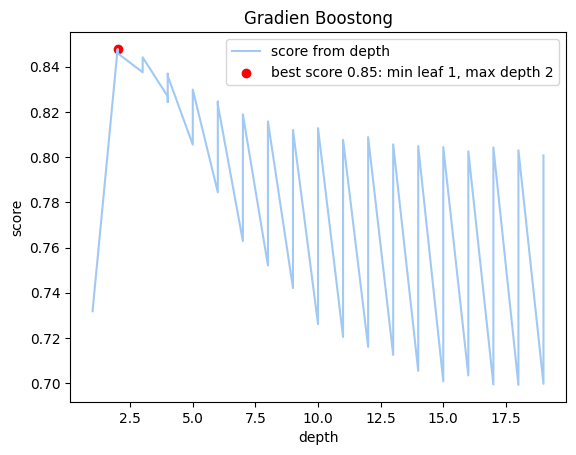

In [69]:
plt.title(f"Gradien Boostong")
plt.xlabel('depth')
plt.ylabel('score')
sns.set_palette("pastel")

plt.plot(plot_depth, plot_score, label = 'score from depth')
plt.scatter(best_depth, best_score, color = 'red', label = f'best score {best_score.round(2)}: min leaf {min_leaf}, max depth {best_depth}')

plt.legend()
plt.show()

In [70]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42, max_depth=best_depth, min_samples_leaf=min_leaf)

In [71]:
model.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [72]:
y_predict_boost = model.predict(x_test)

In [73]:
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test, y_predict_boost))
rmse_2

4402.466576492582

In [74]:
coef_det_2 = metrics.r2_score(y_test, y_predict_boost)
r2_percent_2 = coef_det_2 * 100

In [75]:
r2_percent_2

86.78137872532746

In [105]:
score_depth_leaf = []
plot_score = []
plot_depth = []
for i in range(1, 20):
    for j in range(1, 10):
        model_res = RandomForestRegressor(random_state=42, max_depth = i, min_samples_leaf= j)
        score = cross_val_score(model_res, x_train, y_train, cv = 5)
        score_depth_leaf.append((score.mean(), i, j))
        plot_depth.append(i)
        plot_score.append(score.mean())

def take_score(elem: tuple):
    return elem[0]

max_score = max(score_depth_leaf, key=take_score)
best_score, best_depth, min_leaf = max_score

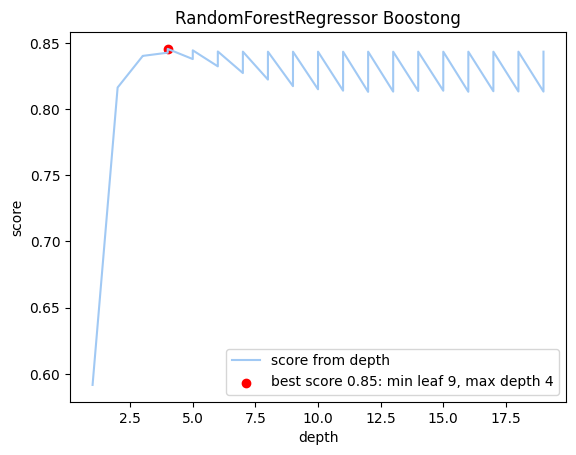

In [106]:
plt.title(f"RandomForestRegressor Boostong")
plt.xlabel('depth')
plt.ylabel('score')
sns.set_palette("pastel")

plt.plot(plot_depth, plot_score, label = 'score from depth')
plt.scatter(best_depth, best_score, color = 'red', label = f'best score {best_score.round(2)}: min leaf {min_leaf}, max depth {best_depth}')

plt.legend()
plt.show()

In [111]:
forest = RandomForestRegressor(max_depth=6, min_samples_leaf=9, random_state=42, n_estimators=200)

In [112]:
forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=9, n_estimators=200,
                      random_state=42)

In [113]:
forest_pred = forest.predict(x_test)

In [114]:
coef_det_2 = metrics.r2_score(y_test, forest_pred)
r2_percent_2 = coef_det_2 * 100
r2_percent_2

87.25390636635672